Aluna: Manuela de Lacerda Bezerra Carvalho (mlbc@cesar.school)

In [ ]:
# Baixa e extrai o dataset
!mkdir data/
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
!unzip data/animais.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.6M  100 11.6M    0     0  1408k      0  0:00:08  0:00:08 --:--:-- 2903k
Archive:  data/animais.zip
   creating: data/animais/
   creating: data/animais/val/
   creating: data/animais/val/tatu/
  inflating: data/animais/val/tatu/10242.jpg  
  inflating: data/animais/val/tatu/10209.jpg  
  inflating: data/animais/val/tatu/10251.jpg  
  inflating: data/animais/val/tatu/10202.jpg  
  inflating: data/animais/val/tatu/10243.jpg  
  inflating: data/animais/val/tatu/10215.jpg  
  inflating: data/animais/val/tatu/10254.jpg  
  inflating: data/animais/val/tatu/10241.jpg  
  inflating: data/animais/val/tatu/10238.jpg  
  inflating: data/animais/val/tatu/10228.jpg  
  inflating: data/animais/val/tatu/10203.jpg  
  inflating: data/animais/val/tatu/10236.jpg  

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [ ]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [ ]:
model = models.resnet18()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

100%|██████████| 13/13 [01:42<00:00,  7.85s/it]


Epoch 1, Train Loss: 0.695, Train Accuracy: 53.25%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.690, Val Accuracy: 54.10%


100%|██████████| 13/13 [01:35<00:00,  7.38s/it]


Epoch 2, Train Loss: 0.729, Train Accuracy: 45.50%
Epoch 2, Val Loss: 0.677, Val Accuracy: 56.56%


100%|██████████| 13/13 [01:35<00:00,  7.33s/it]


Epoch 3, Train Loss: 0.712, Train Accuracy: 53.00%
Epoch 3, Val Loss: 0.687, Val Accuracy: 56.56%


100%|██████████| 13/13 [01:35<00:00,  7.33s/it]


Epoch 4, Train Loss: 0.689, Train Accuracy: 55.50%
Epoch 4, Val Loss: 0.682, Val Accuracy: 54.92%


100%|██████████| 13/13 [01:37<00:00,  7.47s/it]


Epoch 5, Train Loss: 0.697, Train Accuracy: 53.50%
Epoch 5, Val Loss: 0.658, Val Accuracy: 61.48%
Treinamento concluído


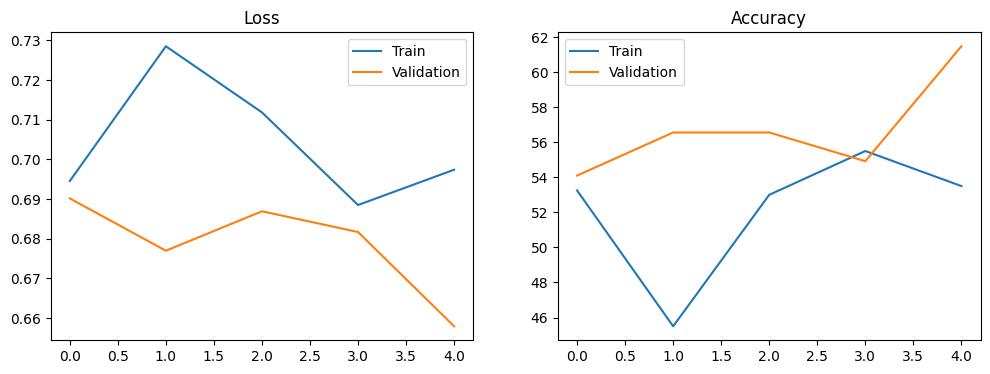

Acurácia da rede na base de teste: 61.48%


In [ ]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

In [ ]:
# Utilizando pesos pré-treinados
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


In [ ]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

100%|██████████| 13/13 [00:35<00:00,  2.70s/it]


Epoch 1, Train Loss: 0.661, Train Accuracy: 58.25%
Epoch 1, Val Loss: 0.431, Val Accuracy: 78.69%


100%|██████████| 13/13 [00:34<00:00,  2.68s/it]


Epoch 2, Train Loss: 0.453, Train Accuracy: 80.50%
Epoch 2, Val Loss: 0.234, Val Accuracy: 91.80%


100%|██████████| 13/13 [00:38<00:00,  2.92s/it]


Epoch 3, Train Loss: 0.315, Train Accuracy: 87.75%
Epoch 3, Val Loss: 0.194, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:36<00:00,  2.81s/it]


Epoch 4, Train Loss: 0.286, Train Accuracy: 89.25%
Epoch 4, Val Loss: 0.149, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:34<00:00,  2.68s/it]


Epoch 5, Train Loss: 0.260, Train Accuracy: 92.00%
Epoch 5, Val Loss: 0.150, Val Accuracy: 95.08%
Treinamento concluído


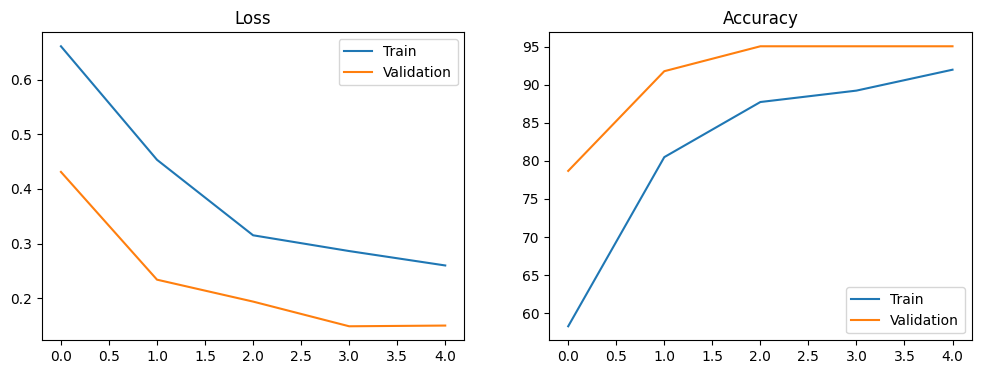

Acurácia da rede na base de teste: 95.08%


In [ ]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

In [ ]:
def plot_and_predict(model, image, class_names, device=device):
    model.eval()
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # image between 0 and 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
images, labels = next(iter(val_loader))

for image, label in zip(images, labels):
    plot_and_predict(model, image, val_set.classes)

Output hidden; open in https://colab.research.google.com to view.

## Exercícios

### Exercício 1
Treine novamente o modelo, mas sem data augmentation. Compare as curvas de treinamento de ambos os casos e comente.

100%|██████████| 13/13 [00:34<00:00,  2.65s/it]


Epoch 1, Train Loss: 0.781, Train Accuracy: 56.50%
Epoch 1, Val Loss: 0.511, Val Accuracy: 72.13%


100%|██████████| 13/13 [00:40<00:00,  3.08s/it]


Epoch 2, Train Loss: 0.399, Train Accuracy: 80.75%
Epoch 2, Val Loss: 0.215, Val Accuracy: 94.26%


100%|██████████| 13/13 [00:35<00:00,  2.75s/it]


Epoch 3, Train Loss: 0.224, Train Accuracy: 93.50%
Epoch 3, Val Loss: 0.189, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:34<00:00,  2.63s/it]


Epoch 4, Train Loss: 0.206, Train Accuracy: 94.00%
Epoch 4, Val Loss: 0.154, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:35<00:00,  2.76s/it]


Epoch 5, Train Loss: 0.177, Train Accuracy: 95.00%
Epoch 5, Val Loss: 0.153, Val Accuracy: 95.08%
Treinamento concluído


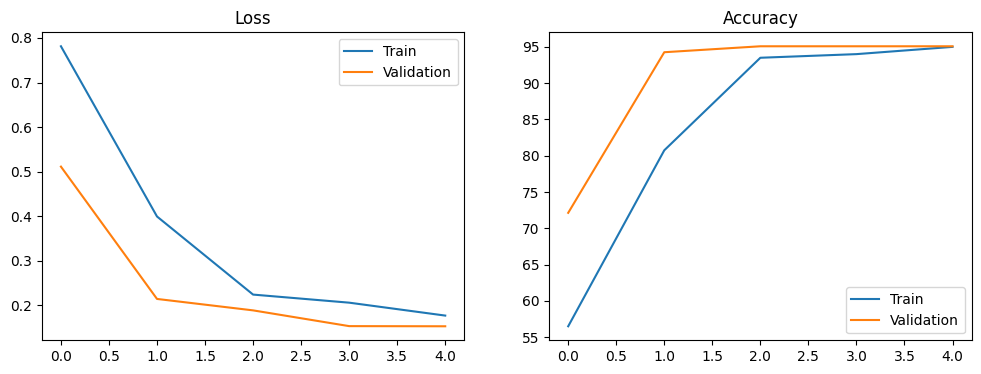

Acurácia da rede na base de teste: 95.08%


In [ ]:
train_set_1 = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
val_set_1 = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader_1 = DataLoader(train_set_1, batch_size=32, shuffle=True)
val_loader_1 = DataLoader(val_set_1, batch_size=32, shuffle=True)

model_1 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for param in model_1.parameters():
    param.requires_grad = False

model_1.fc = nn.Linear(model_1.fc.in_features, 2)
model_1 = model_1.to(device)

criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)

history_1 = train_model(model_1, train_loader_1, val_loader_1, criterion_1, optimizer_1, device, num_epochs=5)

plot_history(history_1)
test_model(model_1, val_loader_1)

Não houve variação na acurácia da última época e na da base de teste. As curvas de perda e da acurácia para teste e validação, desse segundo treinamento, ficaram mais próximas.

### Exercício 2
Descongele mais das últimas camadas (à sua escolha), por exemplo `model.layer4[1]`, e treine novamente o modelo.

100%|██████████| 13/13 [00:48<00:00,  3.77s/it]


Epoch 1, Train Loss: 0.223, Train Accuracy: 92.25%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.121, Val Accuracy: 96.72%


100%|██████████| 13/13 [00:49<00:00,  3.79s/it]


Epoch 2, Train Loss: 0.235, Train Accuracy: 92.25%
Epoch 2, Val Loss: 0.117, Val Accuracy: 96.72%


100%|██████████| 13/13 [00:48<00:00,  3.70s/it]


Epoch 3, Train Loss: 0.199, Train Accuracy: 93.50%
Epoch 3, Val Loss: 0.119, Val Accuracy: 96.72%


100%|██████████| 13/13 [00:48<00:00,  3.76s/it]


Epoch 4, Train Loss: 0.212, Train Accuracy: 92.75%
Epoch 4, Val Loss: 0.108, Val Accuracy: 96.72%


100%|██████████| 13/13 [00:48<00:00,  3.75s/it]


Epoch 5, Train Loss: 0.218, Train Accuracy: 91.75%
Epoch 5, Val Loss: 0.108, Val Accuracy: 95.90%
Treinamento concluído


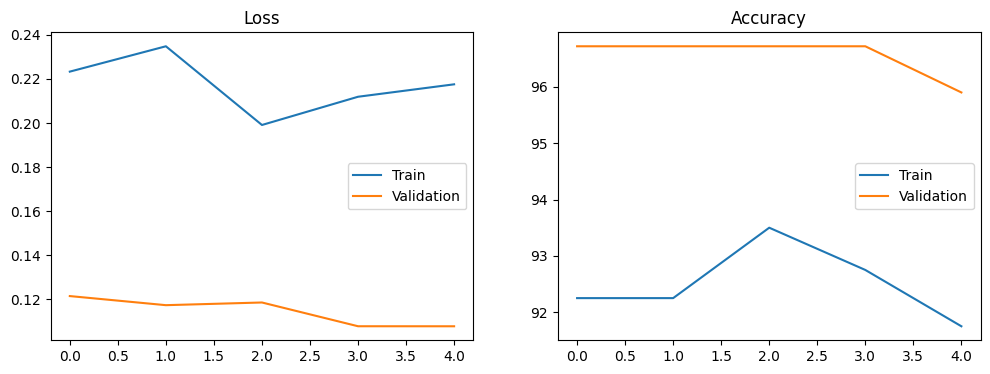

Acurácia da rede na base de teste: 95.90%


In [ ]:
for param in model.layer3[0].parameters():
    param.requires_grad = True

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

### Exercício 3
Escolha outro modelo pré-treinado dos que foram vistos na aula e substitua no modelo. Lembre-se de alterar a última camada de classificação.

In [ ]:
model_2 = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
print(model_2)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

100%|██████████| 13/13 [00:13<00:00,  1.01s/it]


Epoch 1, Train Loss: 0.484, Train Accuracy: 75.25%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.141, Val Accuracy: 92.62%


100%|██████████| 13/13 [00:13<00:00,  1.00s/it]


Epoch 2, Train Loss: 0.325, Train Accuracy: 86.00%
Epoch 2, Val Loss: 0.128, Val Accuracy: 91.80%


100%|██████████| 13/13 [00:13<00:00,  1.01s/it]


Epoch 3, Train Loss: 0.278, Train Accuracy: 88.75%
Epoch 3, Val Loss: 0.129, Val Accuracy: 93.44%


100%|██████████| 13/13 [00:13<00:00,  1.00s/it]


Epoch 4, Train Loss: 0.211, Train Accuracy: 91.25%
Epoch 4, Val Loss: 0.118, Val Accuracy: 92.62%


100%|██████████| 13/13 [00:13<00:00,  1.01s/it]


Epoch 5, Train Loss: 0.165, Train Accuracy: 93.50%
Epoch 5, Val Loss: 0.115, Val Accuracy: 92.62%
Treinamento concluído


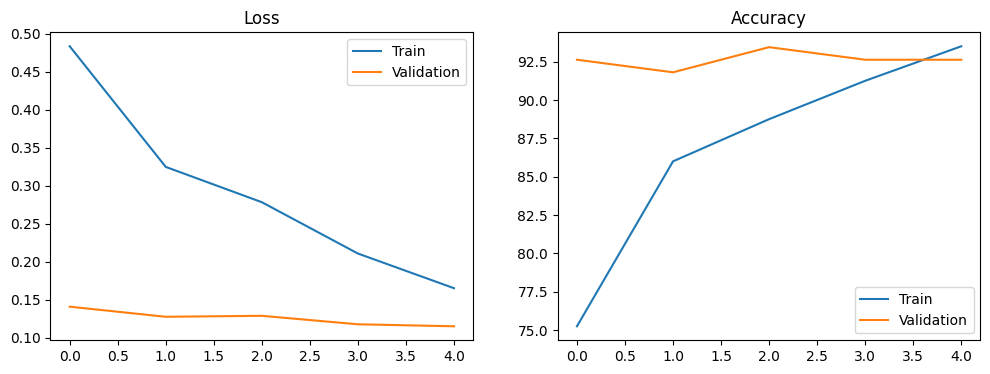

Acurácia da rede na base de teste: 92.62%


In [ ]:
train_set_2 = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set_2 = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader_2 = DataLoader(train_set_2, batch_size=32, shuffle=True)
val_loader_2 = DataLoader(val_set_2, batch_size=32, shuffle=True)

model_2 = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

for param in model_2.parameters():
    param.requires_grad = False

model_2.classifier[6] = nn.Linear(model_2.classifier[6].in_features, 2)
model_2 = model_2.to(device)

criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)

history_2 = train_model(model_2, train_loader_2, val_loader_2, criterion_2, optimizer_2, device, num_epochs=5)

plot_history(history_2)
test_model(model_2, val_loader_2)